In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import googlemaps
import folium
import geopandas

from IPython.display import display
from haversine import haversine

import pyproj
from fiona.crs import from_epsg

## 현재 전북 지역 수소차 충전소

In [67]:
df2 = pd.read_csv('./수소충전소 현황.csv', encoding='cp949')
df2['도'] = [i.split(' ')[0] for i in df2['주소']]
display(df2[df2['도'] == '전북'])

add_list = list(df2[df2['도'] == '전북']['주소']) 
name_list = list(df2[df2['도'] == '전북']['충전소명']) 

gecode_list = []
for i in add_list:
    geocode_result = gmaps.geocode(f'{i}', language='ko')
    gecode_list.append(list(geocode_result[0]['geometry']['location'].values()))

a = folium.Map(gecode_list[1])

for i in gecode_list:
    
    folium.Marker(i, popup = 'hydrogen_car', icon=folium.Icon(icon='cloud')).add_to(a)
    
a

,No,충전소명,구분,공급방식,주소,충전소전화번호,용도,비고,도
7,8,한국에너지기술연구원,제조식,수전해,전북 부안군 하서면 신재생에너지로 20-41,063-580-1670,연구용,휴지,전북
38,39,(재)전북테크노파크 완주수소충전소,저장식,튜브트레일러,전북 완주군 봉동읍 둔산리 951-6,063-262-0083,상업용,NaN,전북
48,49,전주 제1호 수소충전소,저장식,튜브트레일러,"전북 전주시 덕진구 송천동2가 1186-2,1190,1191",NaN,상업용,미개소,전북


## 전북지역 LPG 충전소

In [74]:
df3 = pd.read_csv('./LPG.csv', encoding='cp949')
df3['도'] = [i.split(' ')[0] for i in df3['행정 구역']]
display(df3[df3['도']=='전북'])

lpg_add_ko =list(df3[df3['도']=='전북']['소재지'])
lpg_name =  list(df3[df3['도']=='전북']['업소명'])

lpg_add = []
for i in lpg_add_ko:
    geocode_result = gmaps.geocode(f'{i}', language='ko')
    lpg_add.append(list(geocode_result[0]['geometry']['location'].values()))

q = []
for i in zip(lpg_add, lpg_name):
    q.append(i)
    
lpg_map = folium.Map(lpg_add[50])

for a,b in q:
    
    folium.Marker(a, popup = f"{b}", icon=folium.Icon(icon='cloud')).add_to(lpg_map)
    
lpg_map

,행정 구역,업소명,소재지,전화번호,관리구분,도
1275,전북 고창군,동신충전소,"전북 고창군 신림면 자포리 723-4,723-9",063-564-5150,자동차충전,전북
1276,전북 고창군,NH유통(주)고창고인돌(하)LPG충전소,전북 고창군 신림면 벽송리 557-10,063-561-6318,자동차충전,전북
1277,전북 고창군,고창에너지,전북 고창군 고창읍 주곡리 708-1,063-561-5959,자동차+13kg용기,전북
1278,전북 고창군,(유)광진가스충전소,전북 고창군 고창읍 읍내리 1023-1,063-562-9494,자동차충전,전북
1279,전북 고창군,(유)고창가스충전소,전북 고창군 고창읍 성두리 산27,063-563-1004,자동차충전,전북
...,...,...,...,...,...,...
1413,전북 진안군,진안충전소,전북 진안군 진안읍 구룡리 704-12,063-433-3344,자동차+13kg용기,전북
1414,전북 진안군,한화호텔앤드리조트(주)진안(장수방향)충전소,전북 진안군 진안읍 단양리 171-5외7필지,063-432-6353,자동차충전,전북
1415,전북 진안군,반석충전소,전북 진안군 부귀면 신정리 133-10,063-514-1785,자동차충전,전북
1416,전북 진안군,마이산LPG충전소,"전북 진안군 진안읍 연장리 212-5,산124-3",063-432-5577,자동차충전,전북


## 전북지역 어린이 보호구역

In [78]:
df4 = pd.read_csv('./전라북도 어린이 보호구역.csv', encoding='cp949')
children_safe_location = df4.iloc[:, 4:6]
z = [list(i) for i in np.array(children_safe_location)]

children_safe_map = folium.Map(z[0])

for i in z:
    
    folium.Marker(i, popup = 'LPG', icon=folium.Icon(icon='cloud')).add_to(children_safe_map)
    
children_safe_map


In [47]:
pd.DataFrame(gecode_list, columns=['latitude', 'logitude']).to_csv('./전라북도 수소차 충전소 위치.csv', index=False)
pd.DataFrame(lpg_add, columns=['latitude', 'logitude']).to_csv('./전라북도 LPG 충전소 위치.csv', index=False)
pd.DataFrame(z, columns=['latitude', 'logitude']).to_csv('./전라북도 어린이보호구역 위치.csv', index=False)

## 각각의 LPG 충전소에 가중치 부여
#### 다른 충전소와의 거리
- 2km이내에 다른 충전소가 없을경우 : 1
- 2km이내에 다른 충전소 1개 있을 경우: 2
- 2km이내에 다른 충전소 2개 있을 경우: 3
- 2km이내에 다른 충전소 3개 있을 경우: 4
- 그 이상 : 5 

#### 어린이 보호 구역의 개수
- 5km 이내에 어린이 보호구역이 없을 경우 :1
- 5km 이내에 어린이 보호구역이 5개 미만일 경우 :2
- 5km 이내에 어린이 보호구역이 10개 미만일 경우 :3
- 5km 이내에 어린이 보호구역이 20개 미만일 경우 :4
- 그 이상 : 5



In [91]:
dist = []

for i in range(len(lpg_add)):
    me = lpg_add[i]
    q=[]
    for j in range(len(lpg_add)):
        if i == j:
            continue
        else:
            other = lpg_add[j]
            q.append(round(haversine(me, other), 3))
    
    dist.append(q)   
    
num_below_2km=[]

for i in dist:
    w=[]
    for j in i:
        if j <= 2:
            w.append(j)
    num_below_2km.append(len(w))  
    
lpg = pd.DataFrame(lpg_add, columns=['latitude', 'logitude'])
lpg['num_other_station(2km)'] = num_below_2km

weight = []

for i in num_below_2km:
    if i == 0 :
        weight.append(1)
    elif i == 1:
        weight.append(2)
    elif i == 2:
        weight.append(3)
    elif i == 3:
        weight.append(4)
    else:
        weight.append(5)
        
lpg['weight(num_station)'] = weight

dist2 = []

for i in range(len(lpg_add)):
    me = lpg_add[i]
    q=[]
    for j in range(len(z)):
        other = z[j]
        q.append(round(haversine(me, other), 3))
    
    dist2.append(q)  
    
num_below_5km=[]

for i in dist2:
    w=[]
    for j in i:
        if j <= 5:
            w.append(j)
    num_below_5km.append(len(w))    

weight2 = []

for i in num_below_5km:
    if i == 0 :
        weight2.append(1)
    elif 0< i < 5:
        weight2.append(2)
    elif 5 <= i <10 :
        weight2.append(3)
    elif 10 <= i < 20:
        weight2.append(4)
    else:
        weight2.append(5)
        
lpg['num_safezone(5km)'] = num_below_5km
lpg['weight(safezone)'] = weight2

weight_sum = np.array(lpg.iloc[:,3]) + np.array(lpg.iloc[:,5])
lpg['weight_sum'] = weight_sum
lpg['lpg_name'] = lpg_name

display(lpg)

,latitude,logitude,num_other_station(2km),weight(num_station),num_safezone(5km),weight(safezone),weight_sum,lpg_name
0,35.466973,126.698404,1,2,7,3,5,동신충전소
1,35.467293,126.673257,1,2,7,3,5,NH유통(주)고창고인돌(하)LPG충전소
2,35.433895,126.667795,0,1,7,3,4,고창에너지
3,35.435175,126.691990,1,2,5,3,5,(유)광진가스충전소
4,35.452444,126.696619,2,3,7,3,6,(유)고창가스충전소
...,...,...,...,...,...,...,...,...
138,35.788880,127.441206,1,2,5,3,5,진안충전소
139,35.775723,127.425831,1,2,4,2,4,한화호텔앤드리조트(주)진안(장수방향)충전소
140,35.777786,127.363738,0,1,2,2,3,반석충전소
141,35.777807,127.396738,0,1,4,2,3,마이산LPG충전소


## 가중치가 가장 낮은 주유소(안정성, 다른 주유소와의 거리에서 최적이라고 판단)

In [96]:
first = np.array(lpg[lpg['weight_sum'] == 2].iloc[:, :2]).tolist()[0]
second_list = np.array(lpg[lpg['weight_sum'] == 3].iloc[:,:2]).tolist()

display(lpg[lpg.weight_sum == 2])
new = folium.Map(first)

folium.Marker(first, popup = 'LPG', icon=folium.Icon(icon='cloud')).add_to(new)

for i in gecode_list:
    
    folium.Marker(i, popup = 'hydrogen_car', icon=folium.Icon(color='red')).add_to(new)
new

,latitude,logitude,num_other_station(2km),weight(num_station),num_safezone(5km),weight(safezone),weight_sum,lpg_name
31,35.870989,126.910792,0,1,0,1,2,김제DL충전소


In [97]:
display(lpg[lpg.weight_sum == 3])
new2= folium.Map(second_list[10])

for i in second_list:
    folium.Marker(i, popup = 'LPG', icon=folium.Icon(icon='cloud')).add_to(new2)

for i in gecode_list:
    
    folium.Marker(i, popup = 'hydrogen_car', icon=folium.Icon(color='red')).add_to(new2)

new2

,latitude,logitude,num_other_station(2km),weight(num_station),num_safezone(5km),weight(safezone),weight_sum,lpg_name
20,35.949555,126.593648,0,1,3,2,3,새만금군산충전소
23,35.809731,126.918103,1,2,0,1,3,김제엘피지충전소
25,35.813225,126.921350,1,2,0,1,3,순동연합엘피지충전소
30,35.817543,126.995951,0,1,2,2,3,덕송엘피지충전소
43,36.012814,127.677031,0,1,3,2,3,무주LPG충전소
46,35.597198,126.673661,0,1,2,2,3,줄포엘피지충전소
47,35.660760,126.511791,0,1,1,2,3,변산대박LPG충전소
53,35.747277,127.220290,0,1,2,2,3,죽림충전소
58,35.716128,127.115881,0,1,3,2,3,구이LPG충전소
62,35.717148,127.235048,0,1,1,2,3,(주)춘향이엔지


## 2차원 그래프를 통한 충전소 위치 파악
- latitude, longitude만을 이용하여 k=3(k-meloids)으로 clustering 진행

,geometry
0,POINT (126.69840 35.46697)
1,POINT (126.67326 35.46729)
2,POINT (126.66780 35.43389)
3,POINT (126.69199 35.43518)
4,POINT (126.69662 35.45244)
...,...
138,POINT (127.44121 35.78888)
139,POINT (127.42583 35.77572)
140,POINT (127.36374 35.77779)
141,POINT (127.39674 35.77781)


<AxesSubplot:>

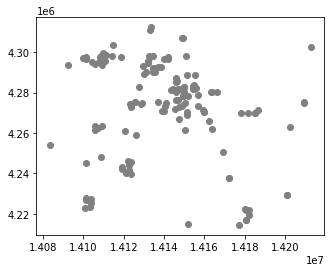

In [92]:
geom_lpg = geopandas.points_from_xy(lpg.logitude, lpg.latitude)


gdf_cctv = geopandas.GeoDataFrame(geometry=geom_lpg, crs=from_epsg(4326))
display(gdf_cctv)

gdf_cctv2 = gdf_cctv.to_crs(epsg=3857)  #좌표계를 epsg 3857로 변환
gdf_cctv2.plot(color='gray')

In [23]:
from sklearn_extra.cluster import KMedoids

In [29]:
X = np.array(lpg.iloc[:,:2]).tolist()
kmedoids = KMedoids(n_clusters=3, random_state=0).fit(X)
kmedoids.labels_

## clustering 중심점 확인

In [93]:
center = kmedoids.cluster_centers_
lpg_map = folium.Map(loc[10])

for i in loc:
    
    folium.Marker(i, popup = 'LPG', icon=folium.Icon(icon='cloud')).add_to(lpg_map)

for i in center.tolist():
    folium.Marker(i, popup = 'k', icon=folium.Icon(color='red')).add_to(lpg_map)    
lpg_map

## final
- 현재 존재하는 수소차 충전소 위치(붉은색)
- clustering을 통해 판단한 중심점 위치(주황색)
- 가중치가 가장 높은 최적의 LPG충전소 위치(곤색)
- 가중치가 두번째로 높은 LPG 충전소 위치(푸른색) 

In [94]:
new2= folium.Map(second_list[0])

for i in second_list:
    folium.Marker(i, popup = 'LPG', icon=folium.Icon(icon='cloud')).add_to(new2)

for i in gecode_list:
    
    folium.Marker(i, popup = 'hydrogen_car', icon=folium.Icon(color='red')).add_to(new2)
    
for i in center.tolist():
    
    folium.Marker(i, popup = 'k-meloids', icon=folium.Icon(color='orange')).add_to(new2)

folium.Marker(first, popup = 'k-meloids', icon=folium.Icon(color='cadetblue')).add_to(new2)    
new2